# Preprocesamiento

In [1]:
import os
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
import dask.dataframe as dd

In [ ]:
# Ruta principal donde están las carpetas con los CSV
ruta_principal = r"/home/raulmartinez/medicalReports/mimic-iv-3.1"

# Diccionario para almacenar los DataFrames de cada módulo
hosp_data = {}
icu_data = {}

# Función para leer archivos comprimidos y almacenarlos en un diccionario
def cargar_datos(ruta_modulo, diccionario):
    for archivo in os.listdir(ruta_modulo):
        # Buscar archivos gz en la carpeta
        if archivo.endswith(".gz"):
            ruta_gz = os.path.join(ruta_modulo, archivo)
            nombre_tabla = archivo.replace(".csv.gz", "")  # Nombre de la tabla sin la extensión
            df = dd.read_csv(ruta_gz, compression="gzip", low_memory=False, blocksize=None, 
                             dtype={'discontinued_by_poe_id': 'object', 'prev_service': 'object', 'dose_val_rx': 'object',
                                    'form_rx': 'object',
                                    'form_val_disp': 'object',
                                    'gsn': 'object',
                                    'ndc': 'float64',
                                    'poe_seq': 'float64',
                                    'expiration_value': 'float64',
                                    'expirationdate': 'object',
                                    'fill_quantity': 'object',
                                    'infusion_type': 'object',
                                    'lockout_interval': 'object',
                                    'one_hr_max': 'object',
                                    'sliding_scale': 'object'})
            diccionario[nombre_tabla] = df
            print(f"Cargado: {nombre_tabla} ({df.shape[0]} filas)")

# Cargar datos de hosp
ruta_hosp = os.path.join(ruta_principal, "hosp")
print ("Cargando datos de hosp...")
cargar_datos(ruta_hosp, hosp_data)

# Cargar datos de icu
ruta_icu = os.path.join(ruta_principal, "icu")
print ("Cargando datos de icu...")
cargar_datos(ruta_icu, icu_data)

Cargando datos de hosp...
Cargado: poe (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(7e7cd2d)).size() // 12, dtype=int64> filas)
Cargado: d_icd_procedures (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(3c08bbb)).size() // 3, dtype=int64> filas)
Cargado: poe_detail (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(df191f1)).size() // 5, dtype=int64> filas)
Cargado: prescriptions (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(231838c)).size() // 21, dtype=int64> filas)
Cargado: omr (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(13bb9a6)).size() // 5, dtype=int64> filas)
Cargado: services (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(aa04086)).size() // 5, dtype=int64> filas)
Cargado: pharmacy (<dask_expr.expr.Scalar: expr=ArrowStringConversion(frame=FromMapProjectable(c0df4a1)).size() // 27, dtype=int64> filas)


: 

In [ ]:
df_hosp = []
# Recorrer los archivos de hosp que contengan subject_id y concatenarlos en un df nuevo
for archivo, df in hosp_data.items():
    if 'subject_id' in df.columns:
        df_hosp.append(df.compute())
    else:
        print(f"Advertencia: {archivo} no tiene 'subject_id'.")


if df_hosp:
    hosp_dataset = pd.concat(df_hosp, ignore_index=True)
    # Guardar en archivos CSV particionados para evitar crash
    hosp_dataset.to_csv("datasets/hosp_dataset_*.csv", index=False)
    print("Dataset hosp unificado guardado exitosamente.")
else:
    print("No se encontraron archivos válidos para unificar.")


Advertencia: d_icd_procedures no tiene 'subject_id'.
Advertencia: d_icd_diagnoses no tiene 'subject_id'.


In [84]:
df_icu = []
# Recorrer los archivos de icu que contengan subject_id y concatenarlos en un df nuevo
for archivo, df in icu_data.items():
    if 'subject_id' in df.columns:
        df_icu.append(df)
    else:
        print(f"Advertencia: {archivo} no tiene 'subject_id'.")


if df_icu:
    icu_dataset = pd.concat(df_icu, ignore_index=True)
    icu_dataset.to_csv("icu_dataset.csv", index=False)
    print("Dataset icu unificado guardado exitosamente.")
else:
    print("No se encontraron archivos válidos para unificar.")

Advertencia: caregiver no tiene 'subject_id'.
Advertencia: d_items no tiene 'subject_id'.
Dataset icu unificado guardado exitosamente.


In [111]:
print(hosp_dataset.columns)
print(f"Cantidad de columnas en hosp_datset: {hosp_dataset.columns.size}")

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance',
       ...
       'form_val_disp', 'form_unit_disp', 'transfertime', 'prev_service',
       'curr_service', 'transfer_id', 'eventtype', 'careunit', 'intime',
       'outtime'],
      dtype='object', length=153)
Cantidad de columnas en hosp_datset: 153


In [86]:
hosp_dataset.dtypes

subject_id       int64
hadm_id        float64
admittime       object
dischtime       object
deathtime       object
                ...   
transfer_id    float64
eventtype       object
careunit        object
intime          object
outtime         object
Length: 153, dtype: object

In [112]:
print(icu_dataset.columns)
print(f"Cantidad de columnas en hosp_datset: {icu_dataset.columns.size}")


Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'charttime',
       'storetime', 'itemid', 'value', 'valuenum', 'valueuom', 'warning',
       'first_careunit', 'last_careunit', 'intime', 'outtime', 'los',
       'starttime', 'endtime', 'amount', 'amountuom', 'rate', 'rateuom',
       'orderid', 'linkorderid', 'statusdescription', 'originalamount',
       'originalrate', 'ordercategoryname', 'secondaryordercategoryname',
       'ordercomponenttypedescription', 'ordercategorydescription',
       'patientweight', 'totalamount', 'totalamountuom', 'isopenbag',
       'continueinnextdept', 'location', 'locationcategory', 'ORIGINALAMOUNT',
       'ORIGINALRATE'],
      dtype='object')
Cantidad de columnas en hosp_datset: 40


In [88]:
icu_dataset.dtypes

subject_id                         int64
hadm_id                            int64
stay_id                            int64
caregiver_id                     float64
charttime                         object
storetime                         object
itemid                           float64
value                             object
valuenum                         float64
valueuom                          object
warning                          float64
first_careunit                    object
last_careunit                     object
intime                            object
outtime                           object
los                              float64
starttime                         object
endtime                           object
amount                           float64
amountuom                         object
rate                             float64
rateuom                           object
orderid                          float64
linkorderid                      float64
statusdescriptio

In [89]:
pd.unique(hosp_dataset['subject_id'])

array([10004235, 10009628, 10018081, 10006053, 10031404, 10005817,
       10019385, 10002495, 10038081, 10019917, 10037861, 10026354,
       10015860, 10020740, 10012552, 10014354, 10039708, 10000032,
       10020786, 10027445, 10015931, 10036156, 10021312, 10003400,
       10023117, 10038992, 10037975, 10035185, 10002930, 10007795,
       10004733, 10021118, 10006580, 10023771, 10005348, 10019172,
       10021487, 10013049, 10035631, 10019003, 10009035, 10040025,
       10014729, 10026255, 10007058, 10018845, 10020640, 10021666,
       10015272, 10016810, 10021938, 10001725, 10001217, 10023239,
       10020944, 10027602, 10032725, 10010471, 10005866, 10024043,
       10018423, 10007928, 10014078, 10008454, 10022281, 10038933,
       10016150, 10022041, 10026406, 10037928, 10029484, 10012853,
       10019777, 10018501, 10004422, 10017492, 10038999, 10009049,
       10016742, 10004457, 10029291, 10004720, 10019568, 10010867,
       10025463, 10002428, 10007818, 10031757, 10039997, 10020

In [90]:
unique_count_hosp = hosp_dataset['subject_id'].nunique()
unique_count_icu = icu_dataset['subject_id'].nunique()

print(f"Cantidad de valores únicos subject_id en hosp_datset: {unique_count_hosp}")
print(f"Cantidad de valores únicos subject_id en icu_datset: {unique_count_icu}")

Cantidad de valores únicos subject_id en hosp_datset: 100
Cantidad de valores únicos subject_id en icu_datset: 100


In [91]:
# Unir todos los DataFrames en uno solo
df_final = pd.concat([hosp_dataset, icu_dataset], ignore_index=True)

# Guardar el dataset unificado
df_final.to_csv("dataset_unificado.csv", index=False)

print("Dataset unificado guardado exitosamente.")

Dataset unificado guardado exitosamente.


In [92]:
# Dimensiones del dataset
print(f"Filas: {df_final.shape[0]}, Columnas: {df_final.shape[1]}")


Filas: 1052656, Columnas: 182


In [93]:
# Primeras filas del dataset
df_final.head()  # primeras 5 filas

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,location,locationcategory,ORIGINALAMOUNT,ORIGINALRATE
0,10004235,24181354.0,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10009628,25926192.0,2153-09-17 17:08:00,2153-09-25 13:20:00,NaN,URGENT,P41R5N,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10018081,23983182.0,2134-08-18 02:02:00,2134-08-23 19:35:00,NaN,URGENT,P233F6,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10006053,22942076.0,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10031404,21606243.0,2113-08-04 18:46:00,2113-08-06 20:57:00,NaN,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Análisis de los datos

In [ ]:
# Resumen estadistico de columnas numéricas
df_final.describe()

,subject_id,hadm_id,hospital_expire_flag,seq_num,icd_version,drg_code,drg_severity,drg_mortality,emar_seq,pharmacy_id,...,orderid,linkorderid,originalamount,originalrate,patientweight,totalamount,isopenbag,continueinnextdept,ORIGINALAMOUNT,ORIGINALRATE
count,1.052656e+06,9.433280e+05,275.000000,8253.000000,5228.000000,454.000000,221.000000,221.000000,107853.000000,9.755300e+04,...,4.760000e+04,4.760000e+04,46132.000000,46132.000000,21872.000000,17090.000000,21872.000000,21872.0,1468.000000,1468.000000
mean,1.001921e+07,2.518211e+07,0.054545,6.967648,9.503826,391.885463,2.805430,2.470588,805.156454,5.079113e+07,...,5.008544e+06,4.939476e+06,140.836524,166.468235,85.879321,216.914593,0.030358,0.0,1428.914715,0.474796
std,1.209243e+04,3.032291e+06,0.227505,7.838858,0.500033,286.875426,0.896035,1.055416,849.945941,2.905366e+07,...,2.906716e+06,2.895123e+06,1230.391559,792.131538,24.074394,283.566500,0.171576,0.0,2867.242930,0.499535
min,1.000003e+07,2.004459e+07,0.000000,1.000000,9.000000,14.000000,1.000000,1.000000,2.000000,1.604000e+03,...,1.974000e+03,1.974000e+03,0.000000,0.000000,1.000000,2.000000,0.000000,0.0,0.168058,0.000000
25%,1.000782e+07,2.258100e+07,0.000000,1.000000,9.000000,182.500000,2.000000,2.000000,180.000000,2.525702e+07,...,2.484713e+06,2.424097e+06,0.000000,10.000000,69.000000,87.300003,0.000000,0.0,1.000000,0.000000
50%,1.001900e+07,2.459702e+07,0.000000,3.000000,10.000000,283.000000,3.000000,2.000000,509.000000,5.158187e+07,...,4.995201e+06,4.870638e+06,0.000000,50.000000,86.200000,100.000000,0.000000,0.0,1.000000,0.000000
75%,1.002760e+07,2.825813e+07,0.000000,11.000000,10.000000,675.750000,3.000000,3.000000,1088.000000,7.653525e+07,...,7.553672e+06,7.415419e+06,50.000000,145.000000,99.600000,250.000000,0.000000,0.0,1712.000000,1.000000
max,1.004002e+07,2.997458e+07,1.000000,39.000000,10.000000,988.000000,4.000000,4.000000,3920.000000,9.999823e+07,...,9.999948e+06,9.999948e+06,25000.001953,75000.007812,143.000000,6500.000000,1.000000,0.0,29051.000000,1.000000


In [ ]:
# Resumen estadistico de columnas categóricas
df_final.describe(include="object")


,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,...,amountuom,rateuom,statusdescription,ordercategoryname,secondaryordercategoryname,ordercomponenttypedescription,ordercategorydescription,totalamountuom,location,locationcategory
count,275,275,15,275,275,275,233,275,275,263,...,46132,27681,47600,21872,14144,20404,21872,17092,353,353
unique,275,275,15,9,170,10,10,3,2,4,...,11,10,5,27,4,3,7,1,43,7
top,2147-12-19 00:00:00,2147-12-21 16:10:00,2111-11-15 17:20:00,EW EMER.,P41R5N,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,SINGLE,...,ml,mL/hour,FinishedRunning,01-Drips,02-Fluids (Crystalloids),Main order parameter,Continuous Med,ml,Right IJ,Peripheral
freq,1,1,1,104,9,134,76,149,255,110,...,32039,22697,30123,8582,11166,13948,8582,17092,36,197


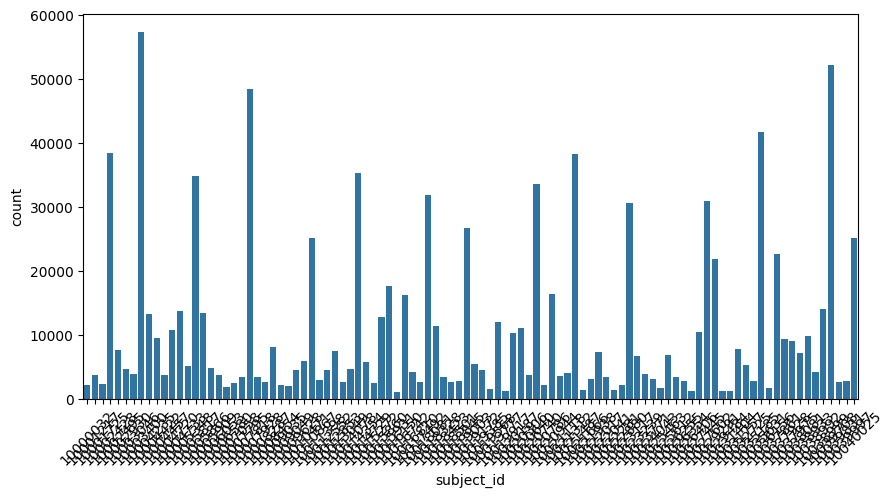

In [114]:
# Distribución de los datos de los distintos pacientes (subject_id)
plt.figure(figsize=(10, 5))
sns.countplot(x="subject_id", data=df_final)
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Estadíticas sobre la edad de los pacientes
df_final['anchor_age'].describe()

count    100.00000
mean      61.75000
std       16.16979
min       21.00000
25%       51.75000
50%       63.00000
75%       72.00000
max       91.00000
Name: anchor_age, dtype: float64

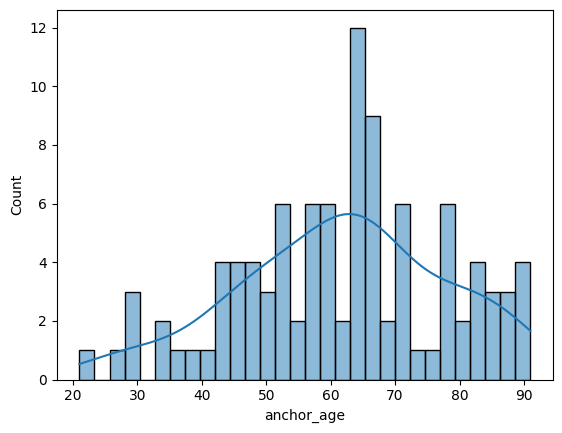

In [ ]:
sns.histplot(df_final['anchor_age'], bins=30, kde=True)
plt.show()


In [95]:
# Calcular duración de la estancia en el hospital
# Convertir columnas a tipo datetime
df_final['admittime'] = pd.to_datetime(df_final['admittime'])
df_final['dischtime'] = pd.to_datetime(df_final['dischtime'])

# Calcular duración de la estancia
df_final['duracion_estancia'] = (df_final['dischtime'] - df_final['admittime']).dt.total_seconds() / (60*60*24)  # en días

# Mostrar resultado
print(df_final[['subject_id', 'duracion_estancia']])

         subject_id  duracion_estancia
0          10004235           8.975000
1          10009628           7.841667
2          10018081           5.731250
3          10006053           1.736806
4          10031404           2.090972
...             ...                ...
1052651    10016742                NaN
1052652    10016742                NaN
1052653    10000032                NaN
1052654    10000032                NaN
1052655    10000032                NaN

[1052656 rows x 2 columns]


C:\Users\raulm\AppData\Local\Temp\ipykernel_10132\3613523460.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['duracion_estancia'] = (df_final['dischtime'] - df_final['admittime']).dt.total_seconds() / (60*60*24)  # en días


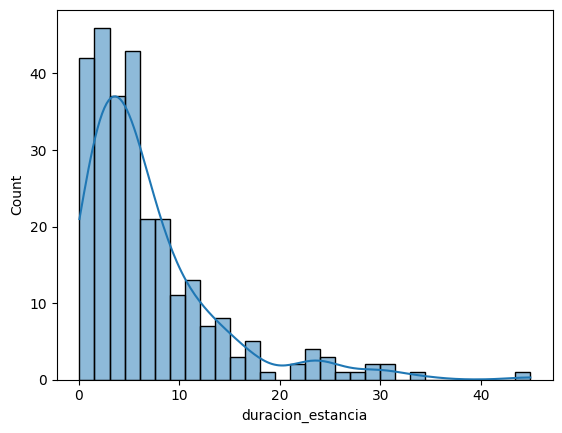

In [ ]:
# Distribución de la duración de estancia
sns.histplot(df_final['duracion_estancia'], bins=30, kde=True)
plt.show()

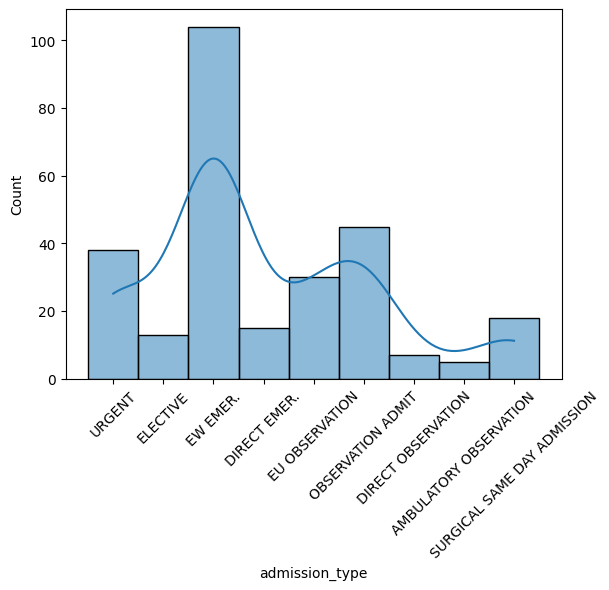

In [78]:
# Distribución del tipo de admisión en hosp
sns.histplot(df_final['admission_type'], bins=30, kde=True)
plt.xticks(rotation=45)
plt.show()

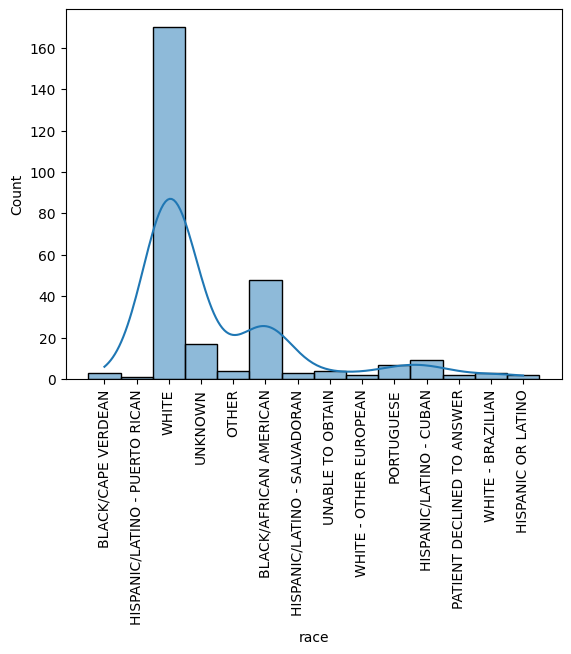

In [77]:
# Distribución de razas
sns.histplot(df_final['race'], bins=30, kde=True)
plt.xticks(rotation=90)
plt.show()

In [109]:
# Tipos de medicacion suministrada en hosp
print(pd.unique(hosp_dataset['medication']))
print(f"Cantidad de valores únicos medication en df_final: {df_final['medication'].nunique()}")

[nan 'Magnesium Sulfate'
 'Potassium Chloride Replacement (Critical Care and Oncology)'
 'Metoprolol Tartrate' 'Morphine Sulfate' 'CefePIME' 'Lidocaine 1%'
 'Magnesium Sulfate Replacement (Critical Care and Oncology)'
 'Fentanyl Citrate' 'Potassium Chloride' 'QUEtiapine Fumarate' 'Insulin'
 'Lidocaine 1% (For PICC/Midline Insertions)' 'Heparin'
 'Calcium Gluconate sliding scale (Critical Care-Ionized calcium)'
 'Albumin 5% (12.5g / 250mL)' 'Albumin 25% (12.5g / 50mL)' 'Ondansetron'
 'Nystatin Cream' 'HYDROmorphone (Dilaudid)' 'LORazepam'
 'OxycoDONE Liquid' 'Readi-Cat 2 (Barium Sulfate 2% Suspension)'
 'Potassium Chloride Replacement (Critical Care and Oncology) '
 'OxycoDONE (Immediate Release) ' 'ALPRAZolam'
 'Morphine Sulfate (Oral Solution) 2 mg/mL' 'Lorazepam' 'Norepinephrine'
 'Midazolam' 'Heparin Flush (10 units/ml)' 'Aspirin' 'Methylprednisolone'
 'OxyCODONE (Immediate Release)' 'sevelamer CARBONATE' 'MoviPrep'
 'Tuberculin Protein' 'Scopolamine Patch' 'Nicotine Patch'
 'Lidoca

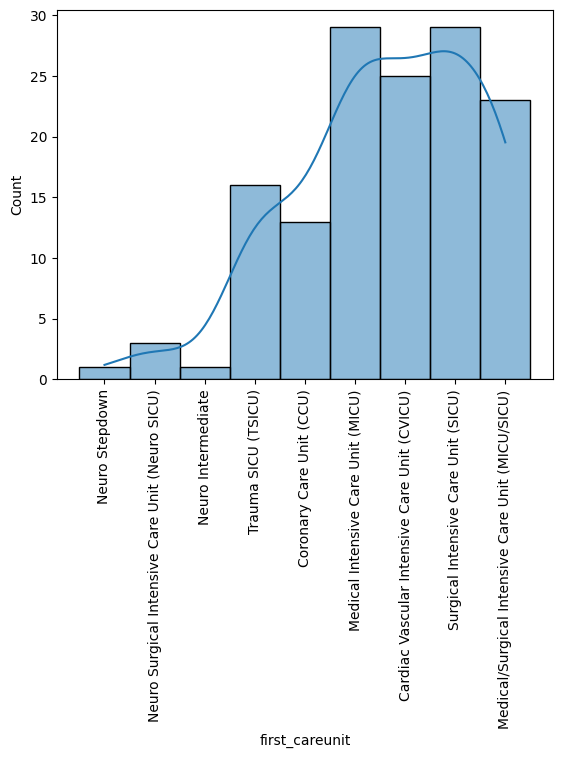

In [73]:
# Distribución de la unidad icu en la que estuvieron los pacientes registrados
sns.histplot(df_final['first_careunit'], bins=30, kde=True)
plt.xticks(rotation=90)
plt.show()

In [79]:
# Calcular duración de la estancia en icu
# Convertir columnas a tipo datetime
df_final['intime'] = pd.to_datetime(df_final['intime'])
df_final['outtime'] = pd.to_datetime(df_final['outtime'])

# Calcular duración de la estancia
df_final['duracion_estancia_icu'] = (df_final['outtime'] - df_final['intime']).dt.total_seconds() / (60*60*24)  # en días

# Mostrar resultado
print(df_final[['subject_id', 'duracion_estancia_icu']])

         subject_id  duracion_estancia_icu
0          10004235                    NaN
1          10009628                    NaN
2          10018081                    NaN
3          10006053                    NaN
4          10031404                    NaN
...             ...                    ...
1052651    10016742                    NaN
1052652    10016742                    NaN
1052653    10000032                    NaN
1052654    10000032                    NaN
1052655    10000032                    NaN

[1052656 rows x 2 columns]


C:\Users\raulm\AppData\Local\Temp\ipykernel_10132\1167001885.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_final['duracion_estancia_icu'] = (df_final['outtime'] - df_final['intime']).dt.total_seconds() / (60*60*24)  # en días


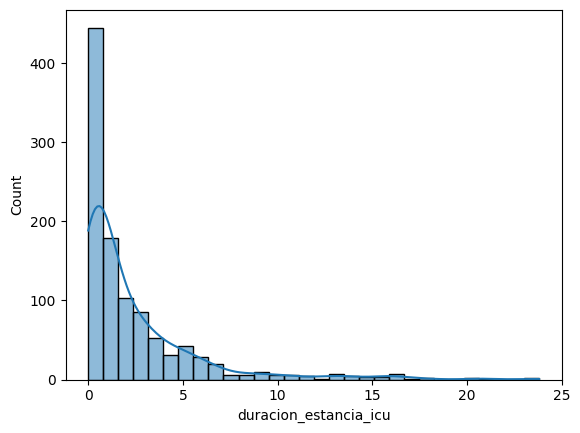

In [ ]:
# Distribución de la duración de estancia en icu
sns.histplot(df_final['duracion_estancia_icu'], bins=30, kde=True)
plt.show()

In [ ]:
df_final['gender'].describe()

count    100.00000
mean      61.75000
std       16.16979
min       21.00000
25%       51.75000
50%       63.00000
75%       72.00000
max       91.00000
Name: anchor_age, dtype: float64

In [25]:
# Datos agrupados por sexo
grouped_data = df_final.groupby('gender')

In [27]:
# Estadísticas para todas las columnas numéricas por sexo
grouped_data.describe()
# Regresa la media de cada columna numérica por sexo
grouped_data.mean(numeric_only=True)

,subject_id,hadm_id,hospital_expire_flag,seq_num,icd_version,drg_code,drg_severity,drg_mortality,emar_seq,pharmacy_id,...,orderid,linkorderid,originalamount,originalrate,patientweight,totalamount,isopenbag,continueinnextdept,ORIGINALAMOUNT,ORIGINALRATE
gender,,,,,,,,,,,,,,,,,,,,,
F,1.001914e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M,1.001850e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


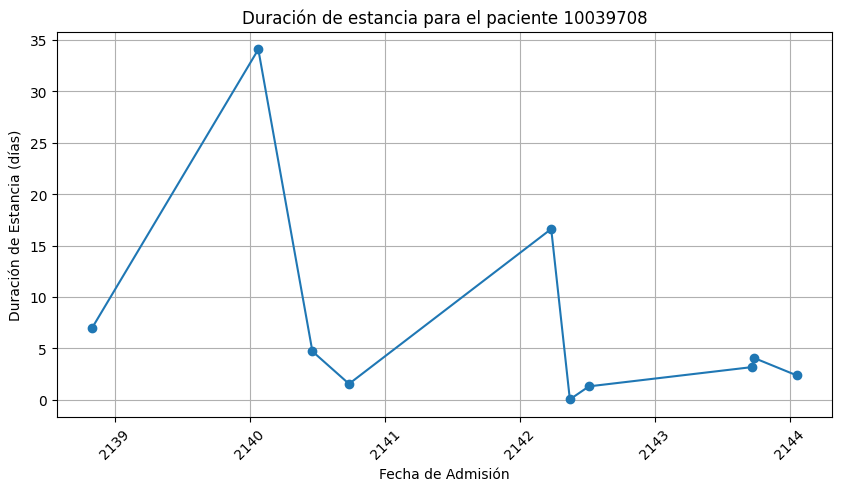

In [ ]:
# Duración estancia de un paciente en concreto
# Filtrar el paciente por su subject_id
subject_id = 10039708
df_paciente = df_final[df_final['subject_id'] == subject_id]

# Asegurar que las fechas están ordenadas
df_paciente = df_paciente.sort_values(by='admittime')

# Graficar la duración de la estancia del paciente
plt.figure(figsize=(10, 5))
plt.plot(df_paciente['admittime'], df_paciente['duracion_estancia'], marker='o', linestyle='-')

# Personalizar la gráfica
plt.xlabel("Fecha de Admisión")
plt.ylabel("Duración de Estancia (días)")
plt.title(f"Duración de estancia para el paciente {subject_id}")
plt.xticks(rotation=45)
plt.grid()

# Mostrar la gráfica
plt.show()
